# **LUCA BACHETTI SPURIO - 0001148019 - AUTOMATION ENGINEERING - 03/02/2025**

# UNet for Image Separation: MNIST + Fashion-MNIST

This notebook demonstrates a UNet model that separates a combined image (sum of two images) into its original components.  The source images are drawn from the MNIST (digits) and Fashion-MNIST (clothing) datasets.

**Key Features:**

*   No preprocessing of input images (except padding to 32x32).
*   The UNet receives the combined image (img1 + img2) as input.
*   The UNet outputs two images: predicted img1 (hat_img1) and predicted img2 (hat_img2).
*   Performance is evaluated using Mean Squared Error (MSE).
*   Includes visualizations of data, model architecture, training progress, and results.
*   Reproducible results by setting random seeds.

# **1. SETUP AND IMPORTS**

This chapter sets up the environment and imports the necessary libraries for building and training a neural network using TensorFlow and Keras. It ensures reproducibility by fixing random seeds for TensorFlow, NumPy, and Python's random module.

#### Steps:

1. **Import TensorFlow and Keras**: Core libraries for building and training neural networks.
   - Specific layers like `Conv2D`, `MaxPooling2D`, and `BatchNormalization` are imported for model construction.
   - The `Adam` optimizer and callbacks like `ModelCheckpoint` are imported for training.

2. **Load Datasets**: MNIST and Fashion MNIST datasets are imported for image classification tasks.

3. **Visualization Tools**:
   - `matplotlib` is used for plotting.
   - `visualkeras` is installed to visualize the neural network architecture.

4. **Additional Libraries**:
   - `numpy` for numerical operations.
   - `PIL` for image handling.
   - `random` for generating random numbers.

5. **Set Random Seeds**: Ensures reproducibility by fixing random seeds for TensorFlow, NumPy, and Python's random module.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.layers import Input, Conv2D, concatenate, MaxPooling2D, Reshape, BatchNormalization, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import numpy as np
from matplotlib import pyplot as plt
!pip install visualkeras
import visualkeras
from PIL import ImageFont
import random

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 19.9 MB/s eta 0:00:00


# **2. DATA LOADING AND PREPARATION**

This section loads the MNIST and Fashion-MNIST datasets, pads the images to a size of 32x32, and normalizes the pixel values to the range `[0, 1]`.

#### Steps:
1. **Load Datasets**:
   - MNIST and Fashion-MNIST datasets are loaded using `mnist.load_data()` and `fashion_mnist.load_data()`.
   - Each dataset is split into training and testing sets (`x` for images, `y` for labels).

2. **Padding and Normalization**:
   - A function `pad_and_normalize` is defined to:
     - Pad 28x28 images to 32x32 using `np.pad`.
     - Normalize pixel values to `[0, 1]` by dividing by 255.

3. **Apply Preprocessing**:
   - The `pad_and_normalize` function is applied to both MNIST and Fashion-MNIST training and testing datasets.

4. **Check Data Sizes**:
   - The shapes of the datasets are printed to verify the preprocessing:
     - Expected training shape: `(60000, 32, 32)`.
     - Expected testing shape: `(10000, 32, 32)`.

In [13]:
# Load MNIST dataset
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()

# Load Fashion-MNIST dataset
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()

# Normalize and pad images to 32x32
def pad_and_normalize(images):
    """Pads images with zeros and normalizes pixel values to [0, 1]."""
    padded_images = np.pad(images, ((0, 0), (2, 2), (2, 2)))
    normalized_images = padded_images / 255.0
    return normalized_images

mnist_x_train = pad_and_normalize(mnist_x_train)
mnist_x_test = pad_and_normalize(mnist_x_test)
fashion_mnist_x_train = pad_and_normalize(fashion_mnist_x_train)
fashion_mnist_x_test = pad_and_normalize(fashion_mnist_x_test)

# Check data sizes
print(f"MNIST training sample size: {mnist_x_train.shape}")
print(f"MNIST test sample size: {mnist_x_test.shape}")
print(f"Fashion-MNIST training sample size: {fashion_mnist_x_train.shape}")
print(f"Padded sample size (MNIST): {mnist_x_train.shape}")

MNIST training sample size: (60000, 32, 32)
MNIST test sample size: (10000, 32, 32)
Fashion-MNIST training sample size: (60000, 32, 32)
Padded sample size (MNIST): (60000, 32, 32)


# **3. DATA GENERATOR**

This section defines a generator function `data_generator` that creates batches of combined images and their corresponding ground truth.
#### Purpose:
- The input to the network is the average of two images: `(img1 + img2) / 2`.
- The target (ground truth) is the concatenation of the two images along the channel dimension.

#### Function Details:
- **Inputs**:
  - `x1`: First dataset (e.g., MNIST images).
  - `x2`: Second dataset (e.g., Fashion-MNIST images).
  - `batch_size`: Number of samples per batch.

- **Outputs**:
  - Yields a tuple `(x_data, y_data)`:
    - `x_data`: Combined image, calculated as `(img1 + img2) / 2`.
    - `y_data`: Concatenated ground truth images along the channel dimension.


In [3]:
def data_generator(x1, x2, batch_size):
    """Generates batches of combined images and ground truth.

    The input to the network is (img1 + img2) / 2.
    The target is the concatenation of img1 and img2 along the channel dimension.

    Args:
        x1: First dataset (e.g., MNIST).
        x2: Second dataset (e.g., Fashion-MNIST).
        batch_size: Number of samples per batch.

    Yields:
        Tuple: (Combined image, concatenated ground truth images).
    """

    n1 = x1.shape[0]
    n2 = x2.shape[0]

    while True:
        # Randomly select indices from both datasets
        indices1 = np.random.randint(0, n1, batch_size)
        indices2 = np.random.randint(0, n2, batch_size)

        # Get the selected images
        batch_x1 = x1[indices1]
        batch_x2 = x2[indices2]

        # Combine images: (img1 + img2) / 2
        x_data = (batch_x1 + batch_x2) / 2.0

        # Concatenate ground truth images along the channel dimension
        y_data = np.concatenate((batch_x1, batch_x2), axis=2)

        yield x_data, y_data

# **4. VISUALIZE SAMPLE DATA**

This section demonstrates how to use the `data_generator` function to create a training data generator and visualize a sample batch.

#### Steps:
1. **Create a Training Data Generator**:
   - A generator is created using the `data_generator` function with a batch size of 1.
   - The generator combines MNIST and Fashion-MNIST training datasets.

2. **Get a Sample Batch**:
   - A single batch is retrieved using the `next` function.
   - The batch contains:
     - `x_sample`: The combined image (average of MNIST and Fashion-MNIST images).
     - `y_sample`: The concatenated ground truth images.

3. **Visualize the Results**:
   - The combined image and the concatenated ground truth are displayed side by side using `matplotlib`.

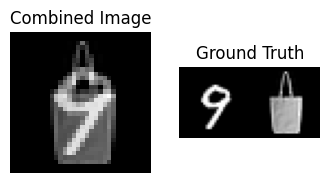

In [16]:
# Create a training data generator with a batch size of 1
train_generator = data_generator(mnist_x_train, fashion_mnist_x_train, 1)

# Get a sample batch
x_sample, y_sample = next(train_generator)

# Display the combined image
plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.imshow(x_sample[0, :, :], cmap='gray')
plt.title('Combined Image')
plt.axis('off')

# Display the concatenated ground truth images
plt.subplot(1, 2, 2)
plt.imshow(y_sample[0, :, :], cmap='gray')
plt.title('Ground Truth')
plt.axis('off')

plt.show()

# **5. UNet MODEL DEFINITION**

The chosen architecture is the UNet, a Convolutional Neural Network originally developed for biomedical image segmentation but now widely used in various segmentation tasks.
Indeed, this section defines a UNet model for image separation tasks; it consists of a downsampling path (encoder), a center layer, and an upsampling path (decoder) with skip connections.

During the contracting phase, the input is progressively reduced in size through convolutional and pooling layers, while the number of filters increases to capture more complex features. In the expansive phase, the network reconstructs the image to its original dimensions using upsampling and convolutional layers, with the number of filters decreasing accordingly.

One of UNet's key innovations is the use of skip connections, which bridge the contracting and expansive paths. These connections allow the network to retain fine-grained spatial information that might otherwise be lost during downsampling. Additionally, skip connections help stabilize training by providing direct gradients to earlier layers, mitigating issues like vanishing gradients and overfitting. This makes UNet particularly effective for tasks requiring precise localization, such as medical image segmentation or object detection in complex scenes.

#### Function: `generate_unet`

This function generates a UNet model with customizable parameters.

#### Arguments:
- **`input_shape`**: Shape of the input images (height, width, channels).
- **`kernel_num`**: Initial number of filters in the convolutional layers. This number doubles at each downsampling level.
- **`floor_num`**: Number of downsampling/upsampling levels (excluding the center layer).
- **`convs_per_floor`**: Number of convolutional layers per downsampling or upsampling level.
- **`batch_norm`**: Whether to use batch normalization after convolutional layers.

#### Returns:
- **`tf.keras.Model`**: The UNet model.

In [5]:
def generate_unet(input_shape, kernel_num=64, floor_num=3, convs_per_floor=2, batch_norm=True):
    """Generates a UNet model for image separation.

    Args:
        input_shape: Shape of the input images (height, width, channels).
        kernel_num: Initial number of filters (doubles each downsampling layer).
        floor_num: Number of downsampling/upsampling levels (excluding the center).
        convs_per_floor: Number of convolutional layers per level.
        batch_norm: Whether to use batch normalization.

    Returns:
        tf.keras.Model: The UNet model.
    """

    unet_input = Input(shape=input_shape, name='InputLayer')

    # Downsampling path
    skip_connections = []
    x = unet_input

    for i in range(floor_num):
        for j in range(convs_per_floor):
            x = Conv2D(kernel_num, 3, activation='relu', padding='same', name=f'DownLayer{i+1}_{j+1}')(x)
            if batch_norm:
                x = BatchNormalization()(x)
        skip_connections.append(x)
        x = MaxPooling2D((2, 2), padding='same', name=f'MaxPoolingLayer{i+1}')(x)
        kernel_num *= 2

    # Center layer
    x = Conv2D(kernel_num, 3, activation='relu', padding='same', name='CenterLayer')(x)
    if batch_norm:
        x = BatchNormalization()(x)

    # Upsampling path
    for k in range(floor_num):
        kernel_num //= 2
        x = UpSampling2D(size=(2, 2))(x)
        x = concatenate([x, skip_connections.pop()])

        for l in range(convs_per_floor):
            x = Conv2D(kernel_num, 3, activation='relu', padding='same', name=f'UpLayer{k+1}_{l+1}')(x)
            if batch_norm:
                x = BatchNormalization()(x)

    # Output layer
    x = Conv2D(2, 1, activation='sigmoid', name='OutputLayer')(x)  # Output 2 channels
    unet_output = Reshape((32, 64, 1))(x)  # Reshape to (32, 64, 1)

    unet = Model(unet_input, unet_output, name='UNet')
    unet.summary()
    return unet

# **6. MODEL INSTANTIATION AND VISUALIZATION**

This section defines the parameters for the UNet model and generates the model using the `generate_unet` function.

#### UNet Parameters:
- **`INPUT_SHAPE`**: Shape of the input images. Set to `(32, 32, 1)` for grayscale images of size 32x32.
- **`INITIAL_KERNELS`**: Number of filters in the first convolutional layer. Set to `64`.
- **`NUM_FLOORS`**: Number of downsampling/upsampling levels in the UNet. Set to `3`.
- **`CONVS_PER_FLOOR`**: Number of convolutional layers per downsampling or upsampling level. Set to `2`.
- **`USE_BATCH_NORM`**: Whether to use batch normalization. Set to `True`.


In [6]:
# UNet Parameters
INPUT_SHAPE = (32, 32, 1)
INITIAL_KERNELS = 64
NUM_FLOORS = 3
CONVS_PER_FLOOR = 2
USE_BATCH_NORM = True

# Generate UNet
unet = generate_unet(INPUT_SHAPE, INITIAL_KERNELS, NUM_FLOORS, CONVS_PER_FLOOR, USE_BATCH_NORM)

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ InputLayer (InputLayer)   │ (None, 32, 32, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ DownLayer1_1 (Conv2D)     │ (None, 32, 32, 64)     │            640 │ InputLayer[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 64)     │            256 │ DownLayer1_1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ DownLayer1_2 (Conv2D)     │ (None, 32, 32, 64)     │         36,928 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 64)     │            256 │ DownLayer1_2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ MaxPoolingLayer1          │ (None, 16, 16, 64)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ DownLayer2_1 (Conv2D)     │ (None, 16, 16, 128)    │         73,856 │ MaxPoolingLayer1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 16, 16, 128)    │            512 │ DownLayer2_1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ DownLayer2_2 (Conv2D)     │ (None, 16, 16, 128)    │        147,584 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 16, 16, 128)    │            512 │ DownLayer2_2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ MaxPoolingLayer2          │ (None, 8, 8, 128)      │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ DownLayer3_1 (Conv2D)     │ (None, 8, 8, 256)      │        295,168 │ MaxPoolingLayer2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 8, 8, 256)      │          1,024 │ DownLayer3_1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ DownLayer3_2 (Conv2D)     │ (None, 8, 8, 256)      │        590,080 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 8, 8, 256)      │          1,024 │ DownLayer3_2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ MaxPoolingLayer3     

 Total params: 5,431,234 (20.72 MB)

 Trainable params: 5,426,626 (20.70 MB)

 Non-trainable params: 4,608 (18.00 KB)

### THE STRUCTURE OF THE NETWORK ARCHITECTURE IS THE FOLLOWING:

/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


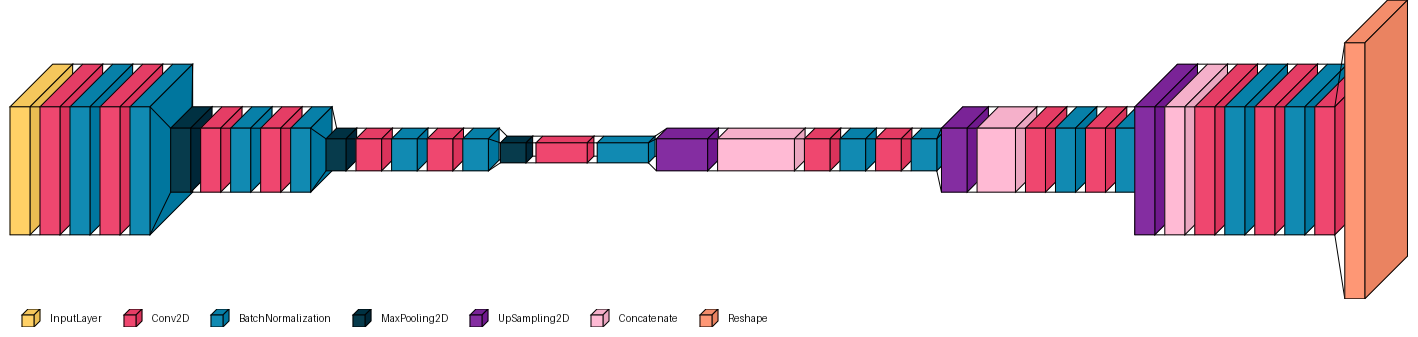

In [7]:
# Visualize the network architecture
font = ImageFont.load_default()
visualkeras.layered_view(unet, legend=True, font=font)

# **7. TRAINING SETUP**

This section defines the training parameters, data generators, and callbacks for training the UNet model.

#### Training Parameters:
- **`BATCH_SIZE`**: Number of samples per batch. Set to `64`.
- **`EPOCHS`**: Number of training epochs. Set to `50`.
- **`STEPS_PER_EPOCH`**: Number of steps per epoch. Calculated as `60000 training samples / 64 batch size = 937.5` (rounded to `937`).
- **`VALIDATION_STEPS`**: Number of validation steps. Calculated as `10000 validation samples / 64 batch size = 156.25` (rounded to `156`).
- **`TEST_STEPS`**: Number of test steps. Calculated as `10000 test samples / 64 batch size = 156.25` (rounded to `156`).

#### Data Generators:
- **`train_generator`**: Generator for training data, combining MNIST and Fashion-MNIST training datasets.
- **`validation_generator`**: Generator for validation data, combining MNIST and Fashion-MNIST testing datasets.
- **`test_generator`**: Generator for test data, combining MNIST and Fashion-MNIST testing datasets.

#### Model Compilation:
- The UNet model is compiled using the Adam optimizer and binary cross-entropy loss.
- Mean Squared Error (MSE) is used as a metric for evaluation.

#### Callbacks:
- **`ModelCheckpoint`**: Saves the best model weights based on validation MSE.
- **`ReduceLROnPlateau`**: Reduces the learning rate if validation MSE does not improve for 5 epochs.

In [8]:
# Training Parameters
BATCH_SIZE = 64
EPOCHS = 50
STEPS_PER_EPOCH = 937   # 60000 training samples / 64 batch size = 937.5
VALIDATION_STEPS = 156  # 10000 validation samples / 64 batch size = 156.25
TEST_STEPS = 156       # 10000 test samples / 64 batch size = 156.25

# Data Generators
train_generator = data_generator(mnist_x_train, fashion_mnist_x_train, BATCH_SIZE)
validation_generator = data_generator(mnist_x_test, fashion_mnist_x_test, BATCH_SIZE)
test_generator = data_generator(mnist_x_test, fashion_mnist_x_test, BATCH_SIZE)


# Compile the model
unet.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['mse']) #optimizer and loss function

# Callbacks
model_checkpoint_callback = ModelCheckpoint(
    filepath='./unet_checkpoint.weights.h5',  # Save to a specific file
    save_weights_only=True,
    monitor='val_mse',  # Monitor validation MSE
    mode='min',
    save_best_only=True,  # Only save the best model
    verbose=1
)

reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_mse',  # Monitor validation MSE
    mode='min',
    patience=5,
    factor=0.1,
    min_lr=0.0001,
    verbose=1
)

# **8. MODEL TRAINING**

This section trains the UNet model using the training and validation data generators. The trained model weights are saved for future use.

#### Training Process:
- The model is trained for a specified number of epochs (`EPOCHS`).
- The training data is fed in batches using the `train_generator`.
- Validation is performed using the `validation_generator`.
- Callbacks are used to monitor and improve the training process:
  - **`ReduceLROnPlateau`**: Reduces the learning rate if validation MSE does not improve.
  - **`ModelCheckpoint`**: Saves the best model weights based on validation MSE.

#### Save Trained Weights:
- After training, the final model weights are saved to a file (`unet_weights.weights.h5`).


In [9]:
# Train the model
history = unet.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS,
    shuffle=True,
    callbacks=[reduce_lr_callback, model_checkpoint_callback]
)

# Save the trained weights
unet.save_weights('unet_weights.weights.h5')

Epoch 1/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.2693 - mse: 0.0374
Epoch 1: val_mse improved from inf to 0.00734, saving model to ./unet_checkpoint.weights.h5
937/937 ━━━━━━━━━━━━━━━━━━━━ 90s 61ms/step - loss: 0.2693 - mse: 0.0374 - val_loss: 0.1394 - val_mse: 0.0073 - learning_rate: 0.0010
Epoch 2/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.1352 - mse: 0.0063
Epoch 2: val_mse improved from 0.00734 to 0.00529, saving model to ./unet_checkpoint.weights.h5
937/937 ━━━━━━━━━━━━━━━━━━━━ 54s 58ms/step - loss: 0.1352 - mse: 0.0063 - val_loss: 0.1318 - val_mse: 0.0053 - learning_rate: 0.0010
Epoch 3/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.1301 - mse: 0.0047
Epoch 3: val_mse improved from 0.00529 to 0.00408, saving model to ./unet_checkpoint.weights.h5
937/937 ━━━━━━━━━━━━━━━━━━━━ 55s 58ms/step - loss: 0.1301 - mse: 0.0047 - val_loss: 0.1300 - val_mse: 0.0041 - learning_rate: 0.0010
Epoch 4/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.1271 - m

# **9. TRAINING HISTORY VISUALIZATION**

This section defines a function `display_history` to visualize the training and validation metrics (MSE and loss) over epochs. The function is then used to display the training results for the UNet model.

#### Function: `display_history`

This function plots the training and validation Mean Squared Error (MSE) and loss over epochs.

#### Arguments:
- **`history`**: The training history object returned by the `fit` method.
- **`model_name`**: Name of the model (used for display purposes).




Results on UNet:



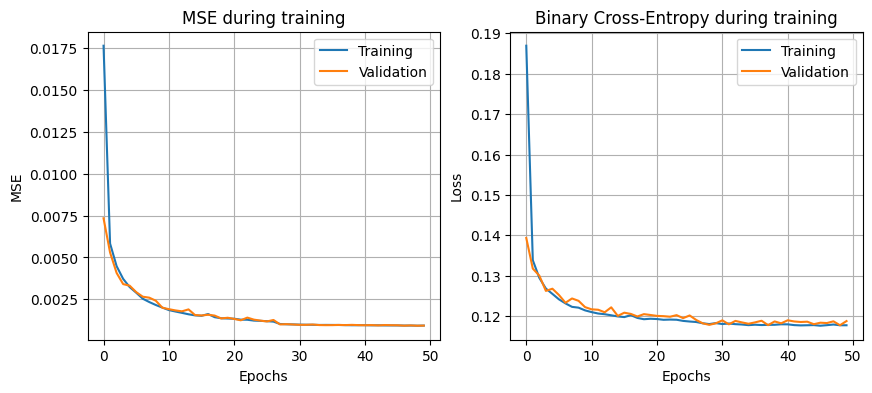

In [10]:
def display_history(history, model_name):
    """Displays the training history (MSE and loss)."""
    mse_training = history.history['mse']
    loss_training = history.history['loss']

    mse_val = history.history['val_mse']
    loss_val = history.history['val_loss']

    print(f'\n\nResults on {model_name}:\n')

    # Visualize MSE
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(mse_training)
    plt.plot(mse_val)
    plt.grid()
    plt.title('MSE during training')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend(['Training', 'Validation'])

    # Visualize Loss
    plt.subplot(1, 2, 2)
    plt.plot(loss_training)
    plt.plot(loss_val)
    plt.grid()
    plt.title('Binary Cross-Entropy during training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.show()


# Display training results
display_history(history, 'UNet')

# **10. MODEL EVALUATION ON TEST SET**

This section evaluates the trained UNet model on the test set multiple times to obtain a robust estimate of the Mean Squared Error (MSE). The standard deviation of the MSE values is also calculated to assess the consistency of the model's performance.

#### Steps:
1. **Multiple Evaluations**:
   - The model is evaluated on the test set `10` times (`num_evaluations`).
   - Each evaluation computes the MSE and loss using the `test_generator`.

2. **Store MSE Values**:
   - The MSE values from each evaluation are stored in a list (`mse_values`).

3. **Calculate Standard Deviation**:
   - The standard deviation of the MSE values is computed to measure the variability in the model's performance.

4. **Display Results**:
   - The computed MSE values and their standard deviation are printed.

In [11]:
# Evaluate the model on the test set multiple times to get a more robust estimate of MSE
mse_values = []
num_evaluations = 10

for i in range(num_evaluations):
    test_loss, test_mse = unet.evaluate(test_generator, steps=TEST_STEPS, verbose=0)
    mse_values.append(test_mse)

mse_stdev = np.std(mse_values, dtype=np.float64)

print("Computed Mean Squared Errors:")
for mse in mse_values:
    print(mse)

print(f"\nStandard deviation of computed Mean Squared Errors:  {mse_stdev}")

Computed Mean Squared Errors:
0.0009363541030324996
0.000939369376283139
0.0009193198056891561
0.0009298708755522966
0.0009241317166015506
0.000929328496567905
0.0009225084213539958
0.0009394102962687612
0.0009367328602820635
0.0009404942393302917

Standard deviation of computed Mean Squared Errors:  7.393056958173222e-06


# **11. VISUALIZE RECONSTRUCTED IMAGES**

This section defines a function `display_reconstructed_images` to visualize the original combined images, the predicted MNIST images, and the predicted Fashion-MNIST images. The function is then used to display sample results from the test set.

#### Function: `display_reconstructed_images`

This function displays a set of original combined images, predicted MNIST images, and predicted Fashion-MNIST images.

#### Arguments:
- **`predicted_images`**: The output of the UNet model, containing the predicted MNIST and Fashion-MNIST images.
- **`x_test`**: The input combined images used for prediction.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Sample Reconstructed Images:


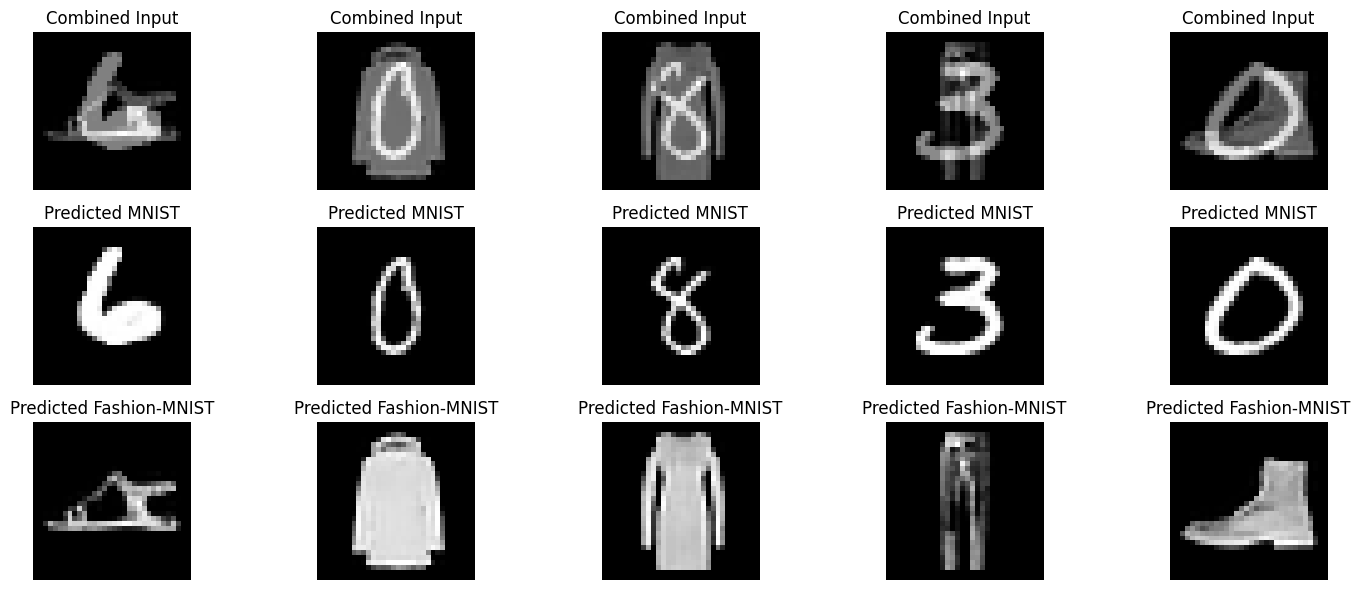

In [12]:
def display_reconstructed_images(predicted_images, x_test):
    """Displays a set of original, combined, and reconstructed images."""
    n = 5  # Number of samples to display
    indices = np.random.choice(x_test.shape[0], size=n, replace=False)  # Randomly select images

    plt.figure(figsize=(15, 6))
    print('Sample Reconstructed Images:')

    for i, idx in enumerate(indices):
        # Original images (MNIST and Fashion-MNIST)
        plt.subplot(3, n, i + 1)
        plt.imshow(x_test[idx, :, :], cmap='gray')
        plt.title('Combined Input')
        plt.axis('off')

        # Predicted images
        plt.subplot(3, n, i + 1 + n)
        plt.imshow(predicted_images[idx, :, :32], cmap='gray') # first image
        plt.title('Predicted MNIST')
        plt.axis('off')

         # Predicted images
        plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(predicted_images[idx, :, 32:], cmap='gray') # second image
        plt.title('Predicted Fashion-MNIST')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# Get a batch of test data and make predictions
x_test, y_test = next(test_generator)
predicted_images = unet.predict(x_test, batch_size=BATCH_SIZE)

# Display the reconstructed images
display_reconstructed_images(predicted_images, x_test)